# Phase 0: Intro

**In this assignment, you will develop Naive Bayes models to perform text classification. The dataset contains texts and the feelings correspond to each text. Your goal is to make a model to predict the emotion associated with each given text.**

Importing necessary libraries

In [1]:
import pandas
import sklearn
import string
import spacy
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

In [8]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 5.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Phase 1: Explore

## Sec 1: Load and Explore the given dataset 

Load the dataset. Look at the head of dataset. How many rows are there in the dataset?




In [13]:
df = pd.read_csv(r"D:\Sharif University of Tech\AI Boot Camp\HW4\SA\Data\train (1).csv")
print(f'Number of rows is {len(df)}')

Number of rows is 5343


Handle missing values 

In [14]:
print(np.where(df.isnull()))
df.isnull().sum()

(array([], dtype=int64), array([], dtype=int64))


ID        0
Text      0
target    0
dtype: int64

Identify the unique feeling values and for each of them, print their count in the dataset. 

In [16]:
df

,ID,Text,target
0,1,i was sent home still feeling a bit shaky and ...,fear
1,2,i feel like i have a little more control and c...,joy
2,3,i have never been happier nor feel more accept...,joy
3,4,i woke up feeling grouchy and irritable didn t...,anger
4,5,i hope i feel mellow well fed well slept at pe...,joy
...,...,...,...
5338,5339,i will admit that i do feel a little envious w...,anger
5339,5340,i was feeling angry at myself for feeling self...,anger
5340,5341,i try to come up with ideas that i feel are cl...,joy
5341,5342,i couldnt help feeling a little envious of wha...,anger


In [17]:
feeling_counts = pd.value_counts(df['target'])
feeling_counts

C:\Users\Acer\AppData\Local\Temp\ipykernel_29660\3317585193.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  feeling_counts = pd.value_counts(df['target'])


target
anger    1811
joy      1808
fear     1724
Name: count, dtype: int64

Plot a pie chart to display the occurance frequency of each genre that you found in the prevoius part.

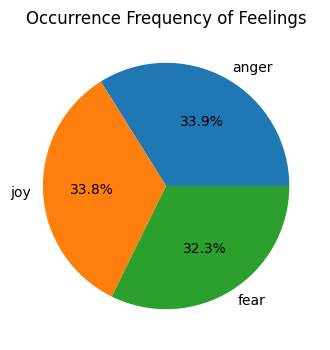

In [18]:
plt.figure(figsize=(4, 4))
plt.pie(feeling_counts, labels=feeling_counts.index, autopct='%1.1f%%')
plt.title('Occurrence Frequency of Feelings')
plt.show()

Find the mean, max and min values of the length (in chars) of the Text Column. 


In [19]:
mean = df['Text'].str.len().mean()
max = df['Text'].str.len().max()
min = df['Text'].str.len().min()
print(f'Mean is {mean}\nMax is {max}\nMin is {min}')

Mean is 97.27306756503837
Max is 298
Min is 9


# Phase 2: Preprocessing

## Sec 1: Preprocess the data 

In [20]:
class Preprocessor:

    def preprocess(self, text):
        text = self.remove_links_and_tags(text)
        words = self.word_tokenize(text)
        words = self.remove_stopwords(words)
        words = self.word_tokenize(words)
        words = self.remove_punctuations(words)
        words = self.word_tokenize(words)
        return ' '.join(words)

    def remove_links_and_tags(self, text):
        doc = nlp(text)
        cleaned_text = ' '.join(token.text for token in doc if not token.like_url and not token.like_email)

        return cleaned_text

    def word_tokenize(self, text):
        return word_tokenize(text)

    def remove_stopwords(self, words):
        stop_words = set(stopwords.words('english'))
        return ' '.join(word for word in words if word.lower() not in stop_words)

    def remove_punctuations(self, words):
        return ' '.join(word.translate(str.maketrans('', '', string.punctuation)) for word in words)

    def normalize(self, words):
        lemmatizer = WordNetLemmatizer()
        return ' '.join(lemmatizer.lemmatize(word) for word in words)

Inspect the dataset for any empty cells or duplicate rows, and if they are present, remove the corresponding rows from the dataset. 

In [21]:
df = df.dropna()
df = df.drop_duplicates()

Clean the Texts by removing the special characters and punctations.

In [22]:
prep = Preprocessor()

df['newText'] = df['Text'].apply(prep.remove_links_and_tags)
df['newText'] = df['newText'].apply(prep.word_tokenize)
df['newText'] = df['newText'].apply(prep.remove_punctuations)
df.head()

,ID,Text,target,newText
0,1,i was sent home still feeling a bit shaky and ...,fear,i was sent home still feeling a bit shaky and ...
1,2,i feel like i have a little more control and c...,joy,i feel like i have a little more control and c...
2,3,i have never been happier nor feel more accept...,joy,i have never been happier nor feel more accept...
3,4,i woke up feeling grouchy and irritable didn t...,anger,i woke up feeling grouchy and irritable didn t...
4,5,i hope i feel mellow well fed well slept at pe...,joy,i hope i feel mellow well fed well slept at pe...


Remove the stop-words from the synopsis texts. Stop-words are those that have a high frequency in the language but don't have much information like 'the', 'and', 'to', etc.

In [23]:
df['newText'] = df['newText'].apply(prep.word_tokenize)
df['newText'] = df['newText'].apply(prep.remove_stopwords)
df.head()

,ID,Text,target,newText
0,1,i was sent home still feeling a bit shaky and ...,fear,sent home still feeling bit shaky dizzy
1,2,i feel like i have a little more control and c...,joy,feel like little control help sweet pea better...
2,3,i have never been happier nor feel more accept...,joy,never happier feel accepted whole life
3,4,i woke up feeling grouchy and irritable didn t...,anger,woke feeling grouchy irritable feel settled da...
4,5,i hope i feel mellow well fed well slept at pe...,joy,hope feel mellow well fed well slept peace wit...


Tokenize the text and convert all characters to their lowercased version 

In [24]:
df['newText'] = df['newText'].apply(prep.word_tokenize)
#df['Text'] = df['Text'].apply(prep.normalize)
df.head()

,ID,Text,target,newText
0,1,i was sent home still feeling a bit shaky and ...,fear,"[sent, home, still, feeling, bit, shaky, dizzy]"
1,2,i feel like i have a little more control and c...,joy,"[feel, like, little, control, help, sweet, pea..."
2,3,i have never been happier nor feel more accept...,joy,"[never, happier, feel, accepted, whole, life]"
3,4,i woke up feeling grouchy and irritable didn t...,anger,"[woke, feeling, grouchy, irritable, feel, sett..."
4,5,i hope i feel mellow well fed well slept at pe...,joy,"[hope, feel, mellow, well, fed, well, slept, p..."


# Phase 3: Training

## Sec 1: Preparing the training feed 

Extract the "X" and "y" numpy array from columns corresponding to text and feelings. 

In [26]:
X = df['Text'].values
y = df['target'].values

Split the dataset into two parts such that the training set (denoted as `x_train` and ‍`y_train`) contains 80% of the samples. 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Extract the text embeddings (feature vectors) for all the texts in the dataset. 

For this task you can use **tf-idf** or **count vectorizer**. Search about them!

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer()

tfidf_vectorizer = TfidfVectorizer()

X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

## Sec 2: Naive Bayes from Scratch 

Complete this section with your code.

In [29]:
class NaiveBayesClassifier:
    def __init__(self, alpha=1):
        '''
        Initialize these:
        Laplace smoothing parameter
        P(Y)
        P(X_i | Y)
        '''
        self.alpha = alpha
        self.class_probs = defaultdict(int)
        self.word_probs = defaultdict(lambda: defaultdict(int))

    def fit(self, X, y):
        '''
        Calculate class probabilities P(Y)
        Calculate word probabilities P(X_i | Y)
        '''
        total_samples = len(y)

        # Calculate class probabilities P(Y)
        for label in np.unique(y):
            label_samples = X[y == label]
            self.class_probs[label] = label_samples.shape[0] / total_samples
            word_counts = np.sum(label_samples, axis=0)
            total_words = np.sum(word_counts)
            word_probs = (word_counts + self.alpha) / (total_words + self.alpha * X.shape[1])
            self.word_probs[label] = word_probs


    def predict(self, X):
        '''
        Calculate the log likelihood of the sample for each class
        Predict the class with the highest score
        '''
        labels = list(self.word_probs.keys())
        predictions = []
        scores = []

        for label in self.class_probs:
            score = np.log(self.class_probs[label])
            word_prob = self.word_probs[label]
            score += np.sum(X * np.log(word_prob.T), axis=1)
            scores.append(score)

        for i in range(len(scores[0])):
            max_score = -10000
            predicted_label = None
            for j in range(len(scores)):
                if scores[j][i] > max_score:
                    max_score = scores[j][i]
                    predicted_label = labels[j]
            predictions.append(predicted_label)

        return predictions



## Sec 3: Fit models to the training data 

Fit a Naive Bayes classifier to the data. (Use both regressors - sklearn & from scratch) 

In [30]:
sklearn_nb = MultinomialNB()
sklearn_nb.fit(X_train, y_train)

MultinomialNB()

In [31]:
my_nb = NaiveBayesClassifier()
my_nb.fit(X_train, y_train)

# Phase 4: Evaluation

## Sec 1: Evaluate both models and compare the results 

Predict the value of "y" for each "x" belonging to the "testing" set (use both models) 

In [32]:
sklearn_y_pred = sklearn_nb.predict(X_test)

In [33]:
scratch_predicted = my_nb.predict(X_test)

Compute Confusion matrix and classification report for each model 

In [34]:
conf_matrix_sklearn = confusion_matrix(y_test, sklearn_y_pred)
class_report_sklearn = classification_report(y_test, sklearn_y_pred)
print(conf_matrix_sklearn)
print(class_report_sklearn)

[[342  12  12]
 [ 24 309  20]
 [ 25  17 308]]
              precision    recall  f1-score   support

       anger       0.87      0.93      0.90       366
        fear       0.91      0.88      0.89       353
         joy       0.91      0.88      0.89       350

    accuracy                           0.90      1069
   macro avg       0.90      0.90      0.90      1069
weighted avg       0.90      0.90      0.90      1069



In [35]:
conf_matrix_scratch = confusion_matrix(y_test, scratch_predicted)
class_report_scratch = classification_report(y_test, scratch_predicted)
print(conf_matrix_scratch)
print(class_report_scratch)

[[342  12  12]
 [ 24 309  20]
 [ 25  17 308]]
              precision    recall  f1-score   support

       anger       0.87      0.93      0.90       366
        fear       0.91      0.88      0.89       353
         joy       0.91      0.88      0.89       350

    accuracy                           0.90      1069
   macro avg       0.90      0.90      0.90      1069
weighted avg       0.90      0.90      0.90      1069



Explain the results of the previous section (what is f1-score? - what is the recall? - what is precision?), also compare the model's performance 


Precision: This measures the accuracy of positive predictions. It's the ratio of correctly predicted positive observations to the total predicted positive observations.

Recall (Sensitivity): Recall calculates the ratio of correctly predicted positive observations to the all observations in the actual class. 

F1-score: This is the harmonic mean of precision and recall and provides a balance between precision and recall.

the performance of these 2 models are the same.

Model Performance Intuition Part: Now, you can test whether your model has a good prediction for a random text.

In [36]:
example = ["Look! behind that tree there is a secret object, I am so scared"]
vectorized = tfidf_vectorizer.transform(example)
print(my_nb.predict(vectorized.toarray()))

['fear']
